> **Problem overview**

"Quick, Draw!" was released as an experimental game to educate the public in a playful way about how AI works. The game prompts users to draw an image depicting a certain category, such as ”banana,” “table,” etc. The game generated more than 1B drawings, of which a subset was publicly released as the basis for this competition’s training set. That subset contains 50M drawings encompassing 340 label categories.

Sounds fun, right? Here's the challenge: since the training data comes from the game itself, drawings can be incomplete or may not match the label. You’ll need to build a recognizer that can effectively learn from this noisy data and perform well on a manually-labeled test set from a different distribution.

Your task is to build a better classifier for the existing Quick, Draw! dataset. By advancing models on this dataset, Kagglers can improve pattern recognition solutions more broadly. This will have an immediate impact on handwriting recognition and its robust applications in areas including OCR (Optical Character Recognition), ASR (Automatic Speech Recognition) & NLP (Natural Language Processing).

In [1]:
# import python standard library
import ast, os, time

# import data manipulation library
import numpy as np
import pandas as pd

# import data visualization library
import matplotlib.pyplot as plt

# import image processing library
import PIL.Image
import PIL.ImageDraw

# import tensorflow model class
import tensorflow as tf

# import sklearn model selection
from sklearn.model_selection import train_test_split

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [2]:
# acquiring training and testing data
df_train = pd.concat([pd.read_csv('../input/train_simplified/' + file, nrows=256) for file in os.listdir('../input/train_simplified')], ignore_index=True)
df_test = pd.read_csv('../input/test_simplified.csv', nrows=64)

In [3]:
# visualize head of the training data
df_train.head(n=5)

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[0, 11, 23, 50, 72, 96, 97, 132, 158, 224, 2...",4926006882205696,True,2017-03-09 00:28:55.637750,bird
1,US,"[[[65, 194, 221, 240, 250, 255, 251, 242, 227,...",5357674197680128,True,2017-03-29 04:22:58.822970,bird
2,US,"[[[159, 163, 175, 189, 201, 209, 227, 245, 253...",5553672849195008,True,2017-03-17 19:31:28.879810,bird
3,DE,"[[[72, 76, 81], [138, 178, 193]], [[87, 116], ...",5635633911431168,True,2017-03-20 14:13:01.811800,bird
4,ZA,"[[[28, 25, 36, 49, 70, 88, 113, 126, 139, 157,...",5696703329992704,False,2017-03-10 13:05:10.002030,bird


In [4]:
# visualize tail of the testing data
df_test.tail(n=5)

,key_id,countrycode,drawing
59,9000485604243837,AU,"[[[4, 32, 53, 67, 98, 114, 145, 170, 199, 221,..."
60,9000491663577318,BE,"[[[9, 10, 6, 0, 1, 20, 26, 86], [74, 165, 225,..."
61,9000497423063288,AU,"[[[111, 100, 81, 75, 75, 79, 93, 125, 149, 169..."
62,9000527546610235,PL,"[[[88, 74, 72, 88, 90, 126, 103, 99, 83], [141..."
63,9000540600886451,BR,"[[[102, 72, 38, 13, 1, 0, 5], [130, 131, 118, ..."


In [5]:
# combine training and testing dataframe
df_train['datatype'], df_test['datatype'] = 'training', 'testing'
df_train = df_train[['key_id', 'countrycode', 'drawing', 'datatype', 'word', 'recognized']]
df_test['word'], df_test['recognized'] = '', True
df_data = pd.concat([df_train, df_test], ignore_index=True)

In [6]:
# data dimensions
img_size = 32
num_channels = 1
num_classes = 340

# flat dimensions
img_size_flat = img_size * img_size * num_channels

> **Feature exploration, engineering and cleansingFeature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [7]:
# imageplot function plot
def imageplot(drawing = None, label = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i in label.index:
        for j in range(len(drawing[i])): _ = axes[i - label.index[0]].plot(drawing[i][j][0], drawing[i][j][1])
        axes[i - label.index[0]].invert_yaxis()
        axes[i - label.index[0]].set_title(label[i])

In [8]:
# feature extraction: drawing
df_data['drawing'] = df_data['drawing'].apply(lambda x: ast.literal_eval(x))

In [9]:
# feature extraction: word
df_data['word'] = df_data['word'].apply(lambda x: x.lower().replace(' ', '_'))

In [10]:
# feature extraction: drawing to pixel
def drawing2pixel(drawing = None):
    image = PIL.Image.new('P', (256, 256), color=255)
    image_draw = PIL.ImageDraw.Draw(image)
    for stroke in drawing:
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], stroke[1][i], stroke[0][i+1], stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((img_size, img_size))
    return 1 - np.array(image).reshape(-1) / 255.0
df_data['pixel'] = df_data['drawing'].apply(lambda x: drawing2pixel(x))

In [11]:
# feature extraction: create pixel columns
df_data = df_data.join(pd.DataFrame(df_data['pixel'].values.tolist()).add_prefix('pixel'))

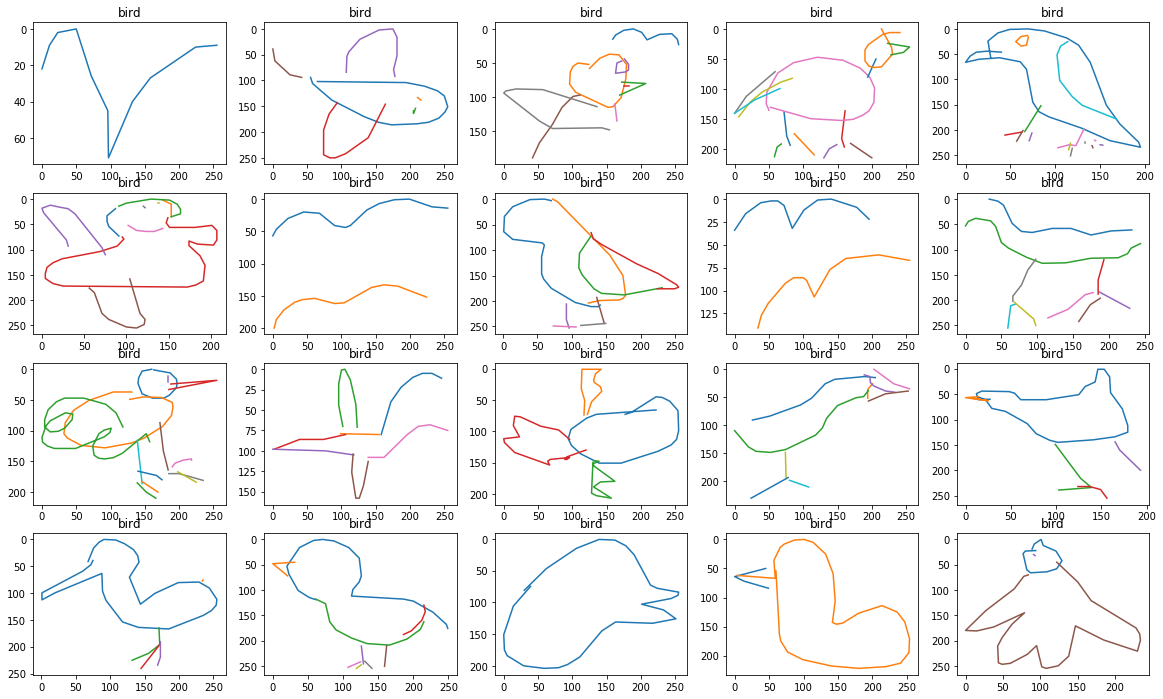

In [12]:
# feature exploration: image
imageplot(df_data.loc[:19, 'drawing'], df_data.loc[:19, 'word'], nrows=4)

After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [13]:
# feature extraction: remove countrycode, drawing and pixel
df_data = df_data.drop(['countrycode', 'drawing', 'pixel'], axis=1)

In [14]:
# convert category codes for data dataframe
df_data = pd.get_dummies(df_data, columns=['datatype', 'word'], drop_first=True)

In [15]:
# describe data dataframe
df_data.describe(include='all')

,key_id,recognized,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,...,word_telephone,word_television,word_tennis_racquet,word_tent,word_the_eiffel_tower,word_the_great_wall_of_china,word_the_mona_lisa,word_tiger,word_toaster,word_toe,word_toilet,word_tooth,word_toothbrush,word_toothpaste,word_tornado,word_tractor,word_traffic_light,word_train,word_tree,word_triangle,word_trombone,word_truck,word_trumpet,word_umbrella,word_underwear,word_van,word_vase,word_violin,word_washing_machine,word_watermelon,word_waterslide,word_whale,word_wheel,word_windmill,word_wine_bottle,word_wine_glass,word_wristwatch,word_yoga,word_zebra,word_zigzag
count,8.710400e+04,87104,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,...,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000,87104.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,80169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.633615e+15,NaN,0.052822,0.064245,0.081489,0.095851,0.109260,0.119696,0.128720,0.136274,0.143369,0.150418,0.154964,0.157318,0.160004,0.160991,0.158959,0.153449,0.149855,0.144356,0.139730,0.134081,0.127021,0.119949,0.114828,0.105919,0.099502,0.094026,0.086035,0.079204,0.072213,0.064142,0.054590,0.050457,0.076001,0.076116,0.082843,0.090088,0.099605,0.105081,...,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939,0.002939
std,6.561286e+14,NaN,0.223679,0.245190,0.273586,0.294388,0.311967,0.324608,0.334891,0.343081,0.350451,0.357483,0.361873,0.364102,0.366612,0.367525,0.365640,0.360422,0.356932,0.351453,0.346708,0.340741,0.332998,0.324903,0.318816,0.307736,0.299336,0.291866,0.280417,0.270059,0.258841,0.245007,0.227179,0.218887,0.265001,0.265185,0.275647,0.286309,0.299474,0

In [16]:
# verify dtypes object
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87104 entries, 0 to 87103
Columns: 1367 entries, key_id to word_zigzag
dtypes: bool(1), float64(1024), int64(1), uint8(341)
memory usage: 709.6 MB


> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [17]:
# select all features
col_pixels = [col for col in df_data if col.startswith('pixel')]
col_words = [col for col in df_data if col.startswith('word')]
x = df_data.loc[(df_data['datatype_training'] == 1) & (df_data['recognized'] == True), col_pixels]
y = df_data.loc[(df_data['datatype_training'] == 1) & (df_data['recognized'] == True), col_words]

In [18]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, random_state=58, test_size=0.25)

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used for inputting data to the graph.
* Variables that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the convolutional network.
* A loss measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables.

In [19]:
# weight variable
def weight_variable(shape, name = None, stddev = 0.1):
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev, seed=58), name=name)

In [20]:
# bias variable
def bias_variable(shape, name = None, value = 0.1):
    return tf.Variable(tf.constant(value, shape=shape), name=name)

In [21]:
# conv2d layer
def conv2d_layer(x, weight, bias, padding = 'SAME', strides = [1, 1, 1, 1]):
    return tf.nn.conv2d(x, weight, strides, padding) + bias

In [22]:
# fully connected layer
def fc_layer(x, weight, bias):
    return tf.matmul(x, weight) + bias

In [23]:
# flatten layer
def flatten_layer(x):
    num_features = x.get_shape()[1:4].num_elements()
    return tf.reshape(x, [-1, num_features]), num_features

In [24]:
# max pool layer
def max_pool_layer(x, ksize = [1, 2, 2, 1], padding = 'SAME', strides = [1, 2, 2, 1]):
    return tf.nn.max_pool(x, ksize, strides, padding)

In [25]:
# relu layer
def relu_layer(x):
    return tf.nn.relu(x)

In [26]:
# reset default graph
tf.reset_default_graph()

In [27]:
# placeholder variables used for inputting data to the graph
x_flat = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x_flat')
x_image = tf.reshape(x_flat, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_class = tf.argmax(y_true, axis=1)

In [28]:
# convolution + relu + max pool layer 1
weight_conv1 = weight_variable([3, 3, num_channels, 32], name='weight_conv1')
bias_conv1 = bias_variable([32], name='bias_conv1')
layer_conv1 = max_pool_layer(relu_layer(conv2d_layer(x_image, weight_conv1, bias_conv1)))

In [29]:
# convolution + relu + max pool layer 2
weight_conv2 = weight_variable([3, 3, 32, 128], name='weight_conv2')
bias_conv2 = bias_variable([128], name='bias_conv2')
layer_conv2 = max_pool_layer(relu_layer(conv2d_layer(layer_conv1, weight_conv2, bias_conv2)))

In [30]:
# flatten layer
layer_flat, num_features = flatten_layer(layer_conv2)

In [31]:
# fully connected + relu layer 1
weight_fc1 = weight_variable([num_features, 512], name='weight_fc1')
bias_fc1 = bias_variable([512], name='bias_fc1')
layer_fc1 = relu_layer(fc_layer(layer_flat, weight_fc1, bias_fc1))

In [32]:
# fully connected + relu layer 2
weight_fc2 = weight_variable([512, num_classes], name='weight_fc2')
bias_fc2 = bias_variable([num_classes], name='bias_fc2')
layer_fc2 = relu_layer(fc_layer(layer_fc1, weight_fc2, bias_fc2))

In [33]:
# predicted class label
y_pred_proba = tf.nn.softmax(layer_fc2)
y_pred_class = tf.argmax(y_pred_proba, axis=1)

In [34]:
# cost function
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=layer_fc2))

In [35]:
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [36]:
# performance metrics
accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred_class, y_true_class), tf.float32))

In [37]:
# counter for total number of iterations performed so far
total_epoch = 0
rndobj = np.random.RandomState(seed=58)

def optimize(num_epoch, printcost = True, printfrequency = 1000, train_batch_size = 256, validate_batch_size = 256):
    global total_epoch
    
    # record start time
    timestart = time.time()
    
    for i in range(total_epoch, total_epoch + num_epoch):
        # specify batch size
        train_index = rndobj.choice(x_train.index, replace=True, size=train_batch_size)
        validate_index = rndobj.choice(x_validate.index, replace=True, size=validate_batch_size)
        
        # tensorflow model fit
        feed_dict_train = {x_flat: x_train.loc[train_index], y_true: y_train.loc[train_index]}
        feed_dict_validate = {x_flat: x_validate.loc[validate_index], y_true: y_validate.loc[validate_index]}
        session.run(optimizer, feed_dict=feed_dict_train)
        
        # print status every 1000 iterations
        if printcost and i % printfrequency == 0: print('epoch: %d, training accuracy: %f, testing accuracy: %f' %(i + 1, session.run(accuracy, feed_dict=feed_dict_train), session.run(accuracy, feed_dict=feed_dict_validate)))
    
    # update the total epoch
    total_epoch += num_epoch
    
    # record end time
    timeend = time.time()
    
    # time elapsed
    timeelapsed = timeend - timestart
    
    # print the time elapsed
    print("elapsed time: %f" %timeelapsed)

In [38]:
# create tensorflow session
session = tf.Session()
session.run(tf.global_variables_initializer())

In [39]:
# tensorflow model fit 1 epoch
optimize(1)

epoch: 1, training accuracy: 0.007812, testing accuracy: 0.007812
elapsed time: 0.859222


In [40]:
# tensorflow model fit 1000 epoch
optimize(1000, printfrequency=100)

epoch: 101, training accuracy: 0.027344, testing accuracy: 0.019531
epoch: 201, training accuracy: 0.019531, testing accuracy: 0.011719
epoch: 301, training accuracy: 0.042969, testing accuracy: 0.039062
epoch: 401, training accuracy: 0.039062, testing accuracy: 0.046875
epoch: 501, training accuracy: 0.062500, testing accuracy: 0.066406
epoch: 601, training accuracy: 0.089844, testing accuracy: 0.066406
epoch: 701, training accuracy: 0.082031, testing accuracy: 0.078125
epoch: 801, training accuracy: 0.082031, testing accuracy: 0.085938
epoch: 901, training accuracy: 0.128906, testing accuracy: 0.117188
epoch: 1001, training accuracy: 0.148438, testing accuracy: 0.085938
elapsed time: 408.741622


> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [41]:
# prepare testing data and compute the observed value
x_test = df_data.loc[df_data['datatype_training'] == 0, col_pixels]
y_test_pred_proba = pd.DataFrame(y_pred_proba.eval(session=session, feed_dict={x_flat: x_test}),
                            columns=col_words, index=df_data.loc[df_data['datatype_training'] == 0, 'key_id'])
yt_test_pred_proba = y_test_pred_proba.T
y_test = []
for i in yt_test_pred_proba.columns:
    df_word = pd.DataFrame(yt_test_pred_proba.nlargest(3, i).index.tolist(), index=['top1', 'top2', 'top3']).T
    df_word['word'] = (df_word['top1'].apply(lambda x: x.replace('word_', '')) + ' ' +
                       df_word['top2'].apply(lambda x: x.replace('word_', '')) + ' ' +
                       df_word['top3'].apply(lambda x: x.replace('word_', '')))
    y_test.append(df_word[['word']])
y_test = pd.concat(y_test, ignore_index=True).set_index(y_test_pred_proba.index)

In [42]:
# summit the results
out = pd.DataFrame({'key_id': y_test.index, 'word': y_test['word']})
out.to_csv('submission.csv', index=False)